In [2]:
pip install transformers torch pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1  # Use GPU if available

pipe = pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone",
    tokenizer="yiyanghkust/finbert-tone",
    device=device,
    function_to_apply="softmax",
    return_all_scores=False
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [5]:
import pandas as pd
df = pd.read_csv("/content/csv_name")

In [8]:
df.head()

,source,title,url,published,content
0,CNBC,"Apple's WWDC underwhelms on AI, but software g...",https://www.cnbc.com/2025/06/09/apple-wwdc-und...,"Tue, 10 Jun 2025 18:00:01 GMT",Apple's annual developer conference on Monday ...
1,CNBC,Google overhauls internal learning platform to...,https://www.cnbc.com/2025/06/10/google-grow-le...,"Tue, 10 Jun 2025 18:46:31 GMT",Google is overhauling a popular internal learn...
2,CNBC,Inflation readings and Treasury auctions to te...,https://www.cnbc.com/2025/06/10/inflation-data...,"Tue, 10 Jun 2025 18:10:22 GMT",Key readings on inflation combined with two cr...
3,CNBC,California asks judge to quickly block Trump t...,https://www.cnbc.com/2025/06/10/trump-marines-...,"Tue, 10 Jun 2025 18:53:29 GMT",California Gov. Gavin Newsom on Tuesday asked ...
4,CNBC,RFK Jr.'s firing of CDC vaccine panel undermin...,https://www.cnbc.com/2025/06/10/rfk-jr-firing-...,"Tue, 10 Jun 2025 18:55:54 GMT",Health and Human Services Secretary Robert F. ...


In [10]:
def preprocess_text(row):
    # Convert to string before stripping to handle potential non-string types (like floats for NaN)
    text = str(row["title"]).strip()
    if pd.notnull(row.get("content")):
        text += " " + str(row["content"]).strip()
    return text.replace("\n", " ").strip()

df["full_text"] = df.apply(preprocess_text, axis=1)
df = df[df["full_text"].str.len() > 30]  # Filter out very short texts

In [11]:
from tqdm.auto import tqdm
import numpy as np

def analyze_sentiment(texts):
    results = pipe(texts, truncation=True, max_length=512, batch_size=8)
    labels = [res["label"] for res in results]
    scores = [round(res["score"], 4) for res in results]
    return labels, scores

batch_size = 50
labels, scores = [], []

for i in tqdm(range(0, len(df), batch_size)):
    texts = df["full_text"].iloc[i:i+batch_size].tolist()
    l, s = analyze_sentiment(texts)
    labels.extend(l)
    scores.extend(s)

df["sentiment"] = labels
df["confidence"] = scores


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
print(df["sentiment"].value_counts())
print(df[["full_text", "sentiment", "confidence"]].head(10))


sentiment
Neutral     66
Positive    19
Negative     5
Name: count, dtype: int64
                                           full_text sentiment  confidence
0  Apple's WWDC underwhelms on AI, but software g...   Neutral      0.9999
1  Google overhauls internal learning platform to...   Neutral      0.8436
2  Inflation readings and Treasury auctions to te...   Neutral      0.9379
3  California asks judge to quickly block Trump t...   Neutral      0.9792
4  RFK Jr.'s firing of CDC vaccine panel undermin...   Neutral      0.9806
5  In China, fears grow of an EV financial crisis...  Negative      0.9658
6  Trump deployment of National Guard, Marines to...   Neutral      1.0000
7  Snap to launch smaller, lighter augmented real...   Neutral      0.9999
8  Immigrant framed for Trump threats can be rele...   Neutral      0.9888
9  2025 CNBC Disruptor 50: See the full list of c...   Neutral      0.9999


<Axes: xlabel='sentiment', ylabel='count'>

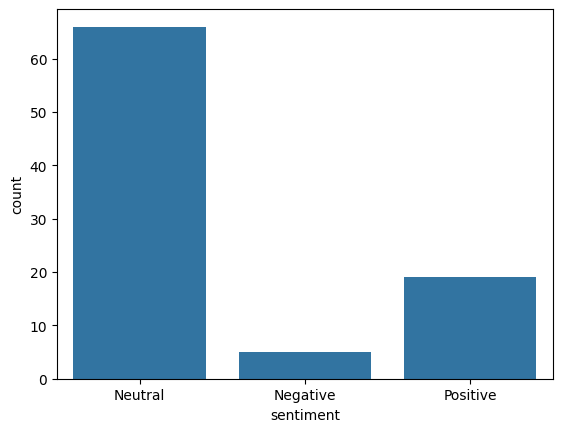

In [13]:
import seaborn as sns
sns.countplot(x="sentiment", data=df)



In [14]:
df.to_csv("finbert_sentiment_results.csv", index=False)
print("Saved to finbert_sentiment_results.csv")


Saved to finbert_sentiment_results.csv
